In [1]:
import pandas as pd

df = pd.read_csv("concatenated_clinical.csv")

print("Önce:", df['treatments.treatment_type'].notna().sum())
df = df[df['cases.submitter_id'].str.startswith("TCGA")]
print("Sonra:", df['treatments.treatment_type'].notna().sum())


# diagnoses.primary_diagnosis'e göre sınıflandır
def classify_diagnosis(value):
    if isinstance(value, str):
        val = value.lower()
        if val.startswith("glio"):
            return "Glioblastoma"
        elif val.startswith("oli"):
            return "Oligodendroglioma"
        elif val.startswith("astro"):
            return "Astrocytoma"
    return "unknown"

for col in df.select_dtypes(include=['float64', 'int64']).columns:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna("Unknown", inplace=True)


df['diagnoses.primary_diagnosis'] = df['diagnoses.primary_diagnosis'].apply(classify_diagnosis)

# Önce 'Unknown' olanları sona at
df = df.sort_values(by='treatments.treatment_type', key=lambda x: x == "Unknown").drop_duplicates(subset=['cases.submitter_id'], keep='first').reset_index(drop=True)


df.to_csv("processed_clinical_with_diagnosis.csv", index=False)

Önce: 2194
Sonra: 1934


/tmp/ipykernel_680603/687367.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/tmp/ipykernel_680603/687367.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# CSV dosyasını oku
df = pd.read_csv("processed_clinical_with_diagnosis.csv")

# Sadece TCGA kayıtlarını al
df = df[df['cases.submitter_id'].str.startswith("TCGA")].reset_index(drop=True)

# Sayısal ve kategorik sütunları ayır
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.difference(['cases.submitter_id']).tolist()

# Sayısal verileri doldur (eksik verileri 0 ile)
numerical_filled = df[numeric_cols].fillna(0)

# Kategorik verileri one-hot encode et
categorical_encoded = pd.get_dummies(df[categorical_cols], dummy_na=True)

deneme = np.concatenate([numerical_filled, categorical_encoded.values], axis=1)

deneme_df = pd.DataFrame(deneme)

deneme_df.to_csv("deneme.csv", index=False)

# Sayısal verileri normalize et
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(numerical_filled)

# Klinik verilerin son hali
processed_clinical_features = np.concatenate([numerical_scaled, categorical_encoded.values], axis=1)

print(f"Klinik veri boyutu: {processed_clinical_features.shape}")


Klinik veri boyutu: (1009, 41)


In [3]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model

vgg16 = load_model('vgg_model.keras')

vgg16.summary()


2025-05-17 23:53:37.361283: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 23:53:37.433488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747515217.461918  680603 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747515217.470204  680603 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747515217.514570  680603 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 19,681,995 (75.08 MB)

 Trainable params: 2,442,371 (9.32 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

 Optimizer params: 4,884,744 (18.63 MB)

In [4]:
import numpy as np
import tensorflow as tf


deneme = np.load("Readformlp/TCGA-TM-A7CF_5b.npy")

print(deneme.shape)

feature_extractor = tf.keras.Model(
    inputs=vgg16.input,
    outputs=vgg16.get_layer("global_average_pooling2d").output
)

(2500, 240, 240)


In [6]:
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf

# Klinik veri
clinical_df = pd.read_csv('processed_clinical_with_diagnosis.csv')

# Klinik verideki tüm ID'ler
clinical_ids = clinical_df['cases.submitter_id'].tolist()


folder_path = 'Readformlp'
clinical_ids = clinical_df['cases.submitter_id'].tolist()

folder_path = 'Readformlp'
clinical_ids = clinical_df['cases.submitter_id'].tolist()

features = []
file_ids = []

for fname in os.listdir(folder_path):
    if fname.endswith('.npy'):
        case_id = fname[:12]
        if case_id in clinical_ids:
            arr = np.load(os.path.join(folder_path, fname))  # (N, 240, 240)
            
            # Eğer slice sayısı 2500'den küçükse geç
            if arr.shape[0] < 2500:
                continue
            # Eğer büyükse ilk 2500'ü al
            elif arr.shape[0] > 2500:
                arr = arr[:2500]

            # 1. Resize ve 3 kanal ekle
            imgs_resized = np.zeros((2500, 224, 224, 3), dtype=np.float32)
            for i in range(2500):
                resized = cv2.resize(arr[i], (224, 224))
                imgs_resized[i] = np.stack([resized]*3, axis=-1)
            
            # 2. Toplu predict
            feature_vectors = feature_extractor.predict(imgs_resized, batch_size=64, verbose=1)  # (2500, 512) (2500,3)
            
            features.append(feature_vectors)
            file_ids.append(case_id)






I0000 00:00:1747515249.535982  680756 service.cc:152] XLA service 0x7e4430002ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747515249.536004  680756 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-17 23:54:09.546887: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747515249.588214  680756 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/40 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

I0000 00:00:1747515253.532893  680756 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [8]:

features = np.array(features) 

# 2. Klinik veriyi sadece file_ids ile filtrele ve aynı sıraya getir
clinical_filtered = clinical_df[clinical_df['cases.submitter_id'].isin(file_ids)]
clinical_filtered = clinical_filtered.set_index('cases.submitter_id').loc[file_ids].reset_index()

clinical_filtered["days_to_death"] = pd.to_numeric(clinical_filtered["demographic.days_to_death"], errors='coerce')

# NaN olan yerlere vital_status'a göre değer ver
clinical_filtered["days_to_death"] = clinical_filtered.apply(
    lambda row: 1825 if pd.isna(row["days_to_death"]) and row["demographic.vital_status"] == "Alive" else row["days_to_death"],
    axis=1
)

# Label atama
def label_days(days):
    if pd.isna(days):
        return np.nan
    elif days <= 125:
        return 0
    elif days <= 325:
        return 1
    elif days <= 625:
        return 2
    elif days <= 1825:
        return 3
    else:
        return 4

clinical_filtered["label"] = clinical_filtered["days_to_death"].apply(label_days)

clinical_filtered = clinical_filtered.dropna(subset=["label"])


grades = clinical_filtered['diagnoses.tumor_grade'].fillna('unknown').values
le_grade = LabelEncoder()
labels_encoded_grade = le_grade.fit_transform(grades)
print("Grade Etiket Sınıfları:", le_grade.classes_)


# Treatment type: ilk virgüle kadar al, boş olanları 'unknown' ile doldur
treatments_raw = clinical_filtered['treatments.treatment_type'].fillna('unknown')
treatments = treatments_raw.apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'unknown')

# Label encode et
le_treatment = LabelEncoder()
labels_encoded_treatment = le_treatment.fit_transform(treatments)
print("Tedavi Türü Etiket Sınıfları:", le_treatment.classes_)

# 3. "unknown" etiketli satırları çıkar
clinical_filtered = clinical_filtered[clinical_filtered['diagnoses.primary_diagnosis'] != 'unknown']

# 4. Features array'i "unknown" etiketlilere göre filtrele
valid_indices = clinical_filtered.index.tolist()
features_filtered = features[valid_indices]

# 5. Etiketleri encode et
labels = clinical_filtered['diagnoses.primary_diagnosis'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

labels_death = clinical_filtered['label'].values

print("Etiket sınıfları:", le.classes_)

# 6. Klinik veriden gerekli feature sütunlarını al
clinical_features = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis']).values


# 4. Feature extraction ve eğitim için hazır

Grade Etiket Sınıfları: ['G2' 'G3' 'G4' 'Unknown']
Tedavi Türü Etiket Sınıfları: ['Antiseizure Treatment' 'Brachytherapy' 'Chemotherapy' 'Hormone Therapy'
 'Immunotherapy (Including Vaccines)' 'Pharmaceutical Therapy' 'Radiation'
 'Radiation Therapy' 'Steroid Therapy' 'Surgery'
 'Targeted Molecular Therapy' 'Unknown']
Etiket sınıfları: ['Astrocytoma' 'Glioblastoma' 'Oligodendroglioma']


In [9]:
# Grade Label Sınıfları
grades = clinical_filtered['diagnoses.tumor_grade'].fillna('unknown').values
le_grade = LabelEncoder()
labels_encoded_grade = le_grade.fit_transform(grades)
print("🎓 Grade Etiket Sınıfları (encoded -> orijinal):")
for idx, cls in enumerate(le_grade.classes_):
    print(f"{idx} -> {cls}")

# Treatment Type Label Sınıfları
treatments_raw = clinical_filtered['treatments.treatment_type'].fillna('unknown')
treatments = treatments_raw.apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'unknown')
le_treatment = LabelEncoder()
labels_encoded_treatment = le_treatment.fit_transform(treatments)
print("\n💉 Tedavi Türü Etiket Sınıfları (encoded -> orijinal):")
for idx, cls in enumerate(le_treatment.classes_):
    print(f"{idx} -> {cls}")

# Primary Diagnosis Label Sınıfları
labels = clinical_filtered['diagnoses.primary_diagnosis'].values
le_diagnosis = LabelEncoder()
labels_encoded_diagnosis = le_diagnosis.fit_transform(labels)
print("\n🧠 Tanı (Primary Diagnosis) Etiket Sınıfları (encoded -> orijinal):")
for idx, cls in enumerate(le_diagnosis.classes_):
    print(f"{idx} -> {cls}")

# Survival Label (days_to_death'ten türetilen)
labels_death = clinical_filtered['label'].values
print("\n⏳ Yaşam Süresi (Survival Class) Etiket Sınıfları (class -> gün aralığı):")
print("0 -> 0-125 gün")
print("1 -> 126-325 gün")
print("2 -> 326-625 gün")
print("3 -> 626-1825 gün")
print("4 -> 1826+ gün")


🎓 Grade Etiket Sınıfları (encoded -> orijinal):
0 -> G2
1 -> G3
2 -> G4
3 -> Unknown

💉 Tedavi Türü Etiket Sınıfları (encoded -> orijinal):
0 -> Antiseizure Treatment
1 -> Brachytherapy
2 -> Chemotherapy
3 -> Hormone Therapy
4 -> Immunotherapy (Including Vaccines)
5 -> Pharmaceutical Therapy
6 -> Radiation
7 -> Radiation Therapy
8 -> Steroid Therapy
9 -> Surgery
10 -> Targeted Molecular Therapy
11 -> Unknown

🧠 Tanı (Primary Diagnosis) Etiket Sınıfları (encoded -> orijinal):
0 -> Astrocytoma
1 -> Glioblastoma
2 -> Oligodendroglioma

⏳ Yaşam Süresi (Survival Class) Etiket Sınıfları (class -> gün aralığı):
0 -> 0-125 gün
1 -> 126-325 gün
2 -> 326-625 gün
3 -> 626-1825 gün
4 -> 1826+ gün


In [10]:
from sklearn.preprocessing import StandardScaler

# Klinik özellikleri al (case_id ve label hariç)
clinical_features_df = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis','diagnoses.tumor_grade','demographic.vital_status' , 'treatments.treatment_type','demographic.days_to_death','days_to_death','label'])

print(clinical_features_df.head())
# 1. Kategorik verileri one-hot encode et
clinical_features_encoded = pd.get_dummies(clinical_features_df)

# 2. Sayısal verileri normalize et
scaler = StandardScaler()
clinical_features_scaled = scaler.fit_transform(clinical_features_encoded)
# Etiketler zaten hazır (labels_encoded)
y = labels_encoded

np.save("y_mlp_pred.npy" , y)
np.save("y2_mlp_pred.npy", labels_death)
np.save("treatments_y.npy",labels_encoded_treatment)
np.save("grade_y.npy" , labels_encoded_grade)
np.save("x_mlp_pred.npy", features_filtered)
np.save("clinic.npy", clinical_features_scaled)


   demographic.days_to_birth  demographic.age_at_index  \
0                      70.20                      70.0   
1                      66.53                      66.0   
2                      54.52                      54.0   
3                      61.07                      61.0   
4                      58.20                      58.0   

   diagnoses.age_at_diagnosis demographic.gender  
0                       70.24             female  
1                       66.53               male  
2                       55.09               male  
3                       61.07             female  
4                       58.20               male  


In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X = np.load("x_mlp_pred.npy")
y = np.load("y_mlp_pred.npy")
y2= np.load("y2_mlp_pred.npy")
y_treatment = np.load("treatments_y.npy")
y_grade = np.load("grade_y.npy")
clinical_data= np.load("clinic.npy")


print(X.shape[0])

print(clinical_data)

data_min = X.min()
data_max = X.max()
X = (X - data_min) / (data_max - data_min)

features_flat = X.reshape(X.shape[0], -1)





797
[[ 1.13270222  1.15366744  1.14167446  1.19577508 -1.19577508]
 [ 0.89669684  0.89652615  0.89557412 -0.83627767  0.83627767]
 [ 0.12437405  0.1251023   0.13670946 -0.83627767  0.83627767]
 ...
 [ 0.66262066  0.63938487  0.69259109 -0.83627767  0.83627767]
 [-1.44535112 -1.41774541 -1.52032193  1.19577508 -1.19577508]
 [-0.0068115  -0.00346834 -0.03642312 -0.83627767  0.83627767]]


In [2]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# One-hot encoding
y_categorical = to_categorical(y, num_classes=3)
y2_categorical = to_categorical(y2, num_classes=5)
y_grade_categorical = to_categorical(y_grade , num_classes=4)
y_treatment_categorical = to_categorical(y_treatment , num_classes=12)

# --- Primary Diagnosis (y) ---
class_indices = np.argmax(y_categorical, axis=1)
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

print("🧠 Primary Diagnosis Sınıf Dağılımı:")
diagnosis_labels = ['Glioblastoma', 'Astrocytoma', 'Oligodendroglioma']
for cls, count in zip(unique_classes, counts):
    label = diagnosis_labels[cls] if cls < len(diagnosis_labels) else "Bilinmeyen"
    print(f"  Sınıf {cls} ({label}): {count} örnek")

# --- Survival Classes (y2) ---
class_indices = np.argmax(y2_categorical, axis=1)
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

print("\n⏳ Yaşam Süresi Sınıf Dağılımı:")
survival_labels = ['0-125', '126-325', '326-625', '625-1825', '1825+']
for cls, count in zip(unique_classes, counts):
    label = survival_labels[cls] if cls < len(survival_labels) else "Bilinmeyen"
    print(f"  Sınıf {cls} ({label} gün): {count} örnek")

# --- Grade Classes ---
class_indices = np.argmax(y_grade_categorical, axis=1)
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

print("\n🎓 Grade Sınıf Dağılımı:")
grade_labels = le_grade.classes_  # Önceki LabelEncoder'dan geliyor
for cls, count in zip(unique_classes, counts):
    label = grade_labels[cls] if cls < len(grade_labels) else "Bilinmeyen"
    print(f"  Sınıf {cls} ({label}): {count} örnek")

# --- Treatment Type Classes ---
class_indices = np.argmax(y_treatment_categorical, axis=1)
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

print("\n💉 Tedavi Türü Sınıf Dağılımı:")
treatment_labels = le_treatment.classes_
for cls, count in zip(unique_classes, counts):
    label = treatment_labels[cls] if cls < len(treatment_labels) else "Bilinmeyen"
    print(f"  Sınıf {cls} ({label}): {count} örnek")

    
    

2025-05-18 02:08:23.586549: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 02:08:23.595380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747523303.604035  874971 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747523303.606516  874971 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747523303.613713  874971 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

🧠 Primary Diagnosis Sınıf Dağılımı:
  Sınıf 0 (Glioblastoma): 185 örnek
  Sınıf 1 (Astrocytoma): 511 örnek
  Sınıf 2 (Oligodendroglioma): 101 örnek

⏳ Yaşam Süresi Sınıf Dağılımı:
  Sınıf 0 (0-125 gün): 75 örnek
  Sınıf 1 (126-325 gün): 114 örnek
  Sınıf 2 (326-625 gün): 163 örnek
  Sınıf 3 (625-1825 gün): 191 örnek
  Sınıf 4 (1825+ gün): 254 örnek

🎓 Grade Sınıf Dağılımı:


NameError: name 'le_grade' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# X: VGG16 çıktı tensorun (örneğin shape=(N, 2500, 512))
# clinical_data: klinik veriler (örneğin shape=(N, 28))
# y: etiketler (örneğin one-hot veya integer)

X_train, X_test, clinical_train, clinical_test, y_train, y_test,y2_train , y2_test , y_grade_train, y_grade_test , y_treatment_train , y_treatment_test = train_test_split(
    X, clinical_data, y_categorical,y2_categorical,y_grade_categorical,y_treatment_categorical,  # veya y integer label olabilir
    test_size=0.2,
    random_state=42,
    stratify=y_categorical  # stratify parametresi etiketlerin dağılımını korur
)

# 📊 Verilerin şekillerini yazdır
print("\n📦 Veri Bölme Sonuçları")
print("--------------------------------------------------")
print("📁 X (Görüntü Tabanlı Özellikler - VGG16 Çıktısı)")
print(f"  🔹 Eğitim: {X_train.shape}")
print(f"  🔹 Test  : {X_test.shape}")

print("\n🧬 Klinik Veriler")
print(f"  🔹 Eğitim: {clinical_train.shape}")
print(f"  🔹 Test  : {clinical_test.shape}")

print("\n🧠 Tanı Etiketleri (Primary Diagnosis - y)")
print(f"  🔹 Eğitim: {y_train.shape}")
print(f"  🔹 Test  : {y_test.shape}")

print("\n⏳ Yaşam Süresi Etiketleri (Survival Class - y2)")
print(f"  🔹 Eğitim: {y2_train.shape}")
print(f"  🔹 Test  : {y2_test.dtype}")
print(y2_train)
y2_train = y2_train.astype("float32")

print("\n🎓 Grade Etiketleri")
print(f"  🔹 Eğitim: {y_grade_train.shape}")
print(f"  🔹 Test  : {y_grade_test.shape}")

print("\n💉 Tedavi Türü Etiketleri")
print(f"  🔹 Eğitim: {y_treatment_train.shape}")
print(f"  🔹 Test  : {y_treatment_test.shape}")
print("--------------------------------------------------")

print("y2_train dtype:", y2_train.dtype)
print("y2_train example:", y2_train[:5])


📦 Veri Bölme Sonuçları
--------------------------------------------------
📁 X (Görüntü Tabanlı Özellikler - VGG16 Çıktısı)
  🔹 Eğitim: (637, 2500, 512)
  🔹 Test  : (160, 2500, 512)

🧬 Klinik Veriler
  🔹 Eğitim: (637, 5)
  🔹 Test  : (160, 5)

🧠 Tanı Etiketleri (Primary Diagnosis - y)
  🔹 Eğitim: (637, 3)
  🔹 Test  : (160, 3)

⏳ Yaşam Süresi Etiketleri (Survival Class - y2)
  🔹 Eğitim: (637, 5)
  🔹 Test  : float64
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]

🎓 Grade Etiketleri
  🔹 Eğitim: (637, 4)
  🔹 Test  : (160, 4)

💉 Tedavi Türü Etiketleri
  🔹 Eğitim: (637, 12)
  🔹 Test  : (160, 12)
--------------------------------------------------
y2_train dtype: float32
y2_train example: [[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, Concatenate



image_input = Input(shape=(2500, 512))  
x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(image_input)
x = Dropout(0.3)(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = GlobalAveragePooling1D()(x)  # -> (batch, 64)

# # Klinik veri girişi
clinical_input = Input(shape=(5,))  # Senin klinik verin kaç feature içeriyorsa

# Birleştirme
combined = Concatenate()([x, clinical_input])  # Doğru kullanım

# MLP Katmanı
fc = Dense(128, activation='relu')(combined)
fc = Dropout(0.5)(fc)
#output = Dense(3, activation='softmax', name='type')(fc)
output_survival = Dense(5, activation='softmax', name='st')(fc)
#output_grade = Dense(4, activation='softmax', name='gr')(fc)
#output_treatment = Dense(12, activation='softmax', name='tr')(fc)

# Model tanımı
model = Model(inputs=[image_input, clinical_input], outputs=[
                                                            #output, 
                                                            output_survival,
                                                            #output_grade,output_treatment
                                                             ])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss={
        
        'st': 'categorical_crossentropy',
        #'type': 'categorical_crossentropy',
        #'gr': 'categorical_crossentropy',
        #'tr': 'categorical_crossentropy'
        
    },
    metrics={
        
        'st': 'accuracy',
        #'type': 'accuracy',
        #'gr': 'accuracy',
        #'tr': 'accuracy'
    })

model.summary()

I0000 00:00:1747523322.729232  874971 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20864 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 2500, 512) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        384 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 2500, 256) │    131,328 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2500, 256) │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ dropout[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     41,088 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ st (Dense)          │ (None, 5)         │        645 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 177,605 (693.77 KB)

 Trainable params: 177,605 (693.77 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping



lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [6]:
y2_train = np.asarray(y2_train).astype("float32")

history = model.fit(
    x=[X_train, clinical_train],
    y=y2_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr ]
)

Epoch 1/200


I0000 00:00:1747523347.778015  875104 service.cc:152] XLA service 0x7f790000d430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747523347.778036  875104 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-18 02:09:08.610187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747523365.189006  875104 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-18 02:09:39.654464: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27045', 52 bytes spill stores, 52 bytes spill loads

2025-05-18 02:09:39.673985: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2704

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2876 - loss: 1.5778

2025-05-18 02:15:12.006823: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27045', 92 bytes spill stores, 92 bytes spill loads

2025-05-18 02:15:12.019159: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27045', 52 bytes spill stores, 52 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 524s 12s/step - accuracy: 0.2844 - loss: 1.5773 - val_accuracy: 0.4062 - val_loss: 1.5549 - learning_rate: 1.0000e-04
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.2784 - loss: 1.5604 - val_accuracy: 0.3828 - val_loss: 1.5354 - learning_rate: 1.0000e-04
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.2838 - loss: 1.5465 - val_accuracy: 0.3750 - val_loss: 1.5157 - learning_rate: 1.0000e-04
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.2976 - loss: 1.5463 - val_accuracy: 0.3672 - val_loss: 1.4973 - learning_rate: 1.0000e-04
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.2873 - loss: 1.5275 - val_accuracy: 0.3828 - val_loss: 1.4788 - learning_rate: 1.0000e-04
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3319 - loss: 1.5039 - val_accuracy: 0.3828 - val_loss: 1.4594 - learning_rate: 1.0000e-04
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3154 - lo

In [17]:
history = model.fit(
    [X_train,clinical_train],
    {
        
        'st': y2_train,
        #'type': y_train,
        #'gr': y_grade_train,
        #'tr' : y_treatment_train
    },
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        lr, 
        #es
        ]
)


Epoch 1/200


TypeError: Expected float32, but got st of type 'str'.

KeyError: 'gr_accuracy'

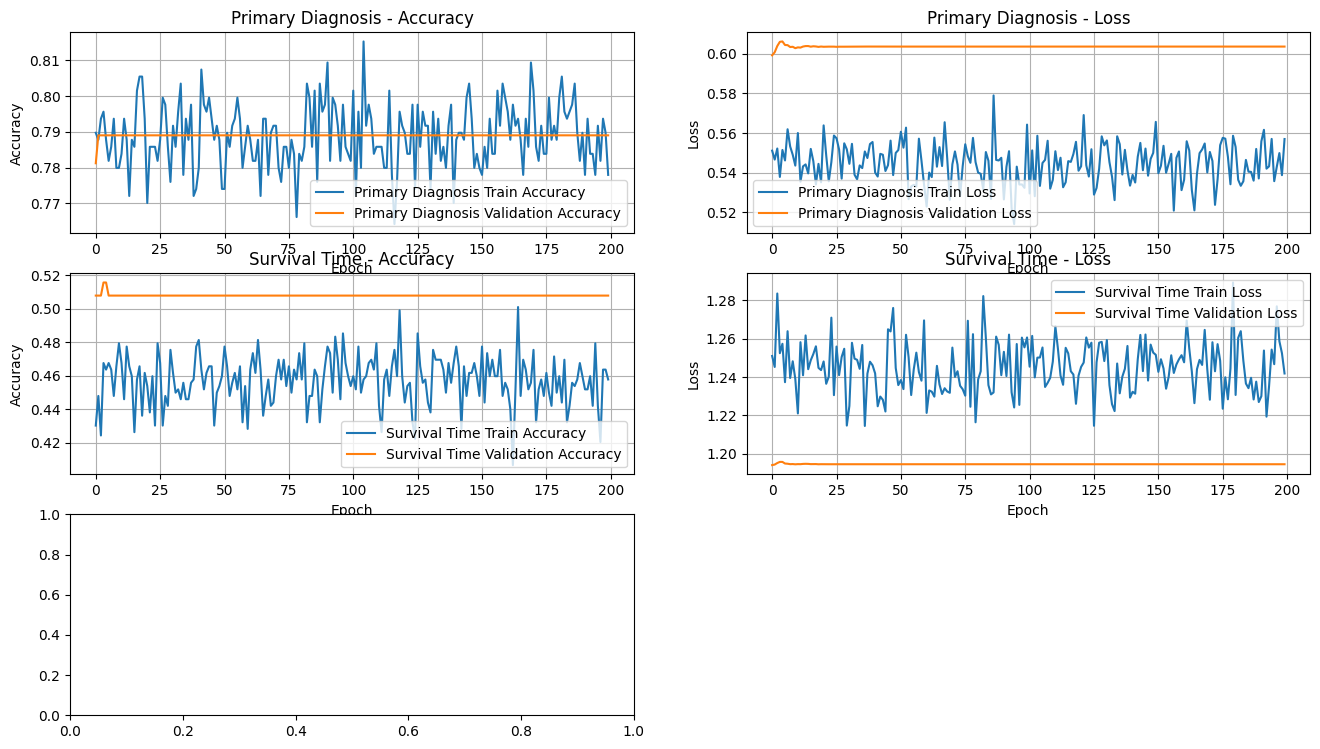

In [26]:
import matplotlib.pyplot as plt

output_names = {
    'type': 'Primary Diagnosis',
    'st': 'Survival Time',
    'gr': 'Tumor Grade',
    'tr': 'Treatment Type'
}

metrics = ['accuracy', 'loss']

plt.figure(figsize=(16, 12))

plot_idx = 1

for output_key, output_title in output_names.items():
    for metric in metrics:
        train_key = f"{output_key}_{metric}"
        val_key = f"val_{output_key}_{metric}"
        
        plt.subplot(len(output_names), 2, plot_idx)
        plt.plot(history.history[train_key], label=f'{output_title} Train {metric.capitalize()}')
        plt.plot(history.history[val_key], label=f'{output_title} Validation {metric.capitalize()}')
        plt.title(f'{output_title} - {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plot_idx += 1

plt.tight_layout()
plt.show()


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model tahminleri
y_pred_proba = model.predict([X_test, clinical_test])

# Argmax ile tahmin sınıf indekslerini al
y_pred_type = np.argmax(y_pred_proba[0], axis=1)
y_pred_survival = np.argmax(y_pred_proba[1], axis=1)
y_pred_grade = np.argmax(y_pred_proba[2], axis=1)
y_pred_treatment = np.argmax(y_pred_proba[3], axis=1)

# Gerçek etiketleri argmax ile al
y_true_type = np.argmax(y_test, axis=1)
y_true_survival = np.argmax(y2_test, axis=1)
y_true_grade = np.argmax(y_grade_test, axis=1)
y_true_treatment = np.argmax(y_treatment_test, axis=1)

# Etiket isimleri
label_names_type = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
label_names_survival = ['0-125', '126-325', '326-625', '626-1825', '1825+']
label_names_grade = le_grade.classes_  # örn: ['G2', 'G3', 'G4', 'unknown']
label_names_treatment = le_treatment.classes_  # örn: ['Drug', 'Radiation', ..., 'unknown']

# Plot fonksiyonu
def plot_cm(y_true, y_pred, labels, title, cmap='Blues'):
    n_labels = len(labels)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_labels))  # 🛠️ Zorla tüm sınıfları dahil et
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(6, 6))
    disp.plot(cmap=cmap, values_format='d')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Confusion Matrix’leri çiz
plot_cm(y_true_type, y_pred_type, label_names_type, "Confusion Matrix (Type Prediction)", cmap='Blues')
plot_cm(y_true_survival, y_pred_survival, label_names_survival, "Confusion Matrix (Survival Time Prediction)", cmap='Purples')
plot_cm(y_true_grade, y_pred_grade, label_names_grade, "Confusion Matrix (Tumor Grade Prediction)", cmap='Greens')
plot_cm(y_true_treatment, y_pred_treatment, label_names_treatment, "Confusion Matrix (Treatment Type Prediction)", cmap='Oranges')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


IndexError: list index out of range